In [1]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# --- 2. Set Paths ---
csv_path = r'C:\Users\HP\Downloads\elpv_dataset\elpv_dataset-1.0.0.post1\src\elpv_dataset\data\labels.csv'
img_dir = r'C:\Users\HP\Downloads\elpv_dataset\elpv_dataset-1.0.0.post1\src\elpv_dataset\data\images'

In [3]:
# --- 3. Data Collection ---
df = pd.read_csv(csv_path)
print("Data Shape:", df.shape)
print(df.head())

Data Shape: (2623, 1)
   images/cell0001.png  1.0                 mono
0  images/cell0002.png  1.0                 mono
1  images/cell0003.png  1.0                 mono
2  images/cell0004.png  0.0                 mono
3  images/cell0005.png  1.0                 mono
4  images/cell0006.png  1.0                 mono


In [4]:
# --- 4. Preprocessing ---
def load_images(image_names, img_dir, size=(64, 64)):
    images = []
    for name in image_names:
        path = os.path.join(img_dir, name.lstrip("images/"))
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, size)
            images.append(img.flatten())
        else:
            images.append(np.zeros(size[0] * size[1] * 3))
    return np.array(images)

# Reload CSV with proper delimiter
df = pd.read_csv(csv_path, sep=r'\s+', header=None, engine='python')
df.columns = ['image_path', 'class', 'type']  # Rename columns appropriately

print(df.head())
X = load_images(df['image_path'], img_dir)
y = df['class']

            image_path  class  type
0  images/cell0001.png    1.0  mono
1  images/cell0002.png    1.0  mono
2  images/cell0003.png    1.0  mono
3  images/cell0004.png    0.0  mono
4  images/cell0005.png    1.0  mono


In [15]:
# --- 5. Cross Validation Setup (K-Fold) ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metrics_summary = []

round_num = 1
for train_index, test_index in kf.split(X):
    print(f"\n--- Round {round_num} ---")

    # --- Grey Box Testing: Train and Reason ---
    X_train, X_test = X[train_index], X[test_index]
    
    # Ensure y is a NumPy array of integers
    y_array = y.values.astype(int)
    y_train, y_test = y_array[train_index], y_array[test_index]

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # --- Indicator Statistics ---
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    metrics_summary.append([acc, prec, rec, f1])

    round_num += 1


--- Round 1 ---
Accuracy: 0.8590, Precision: 0.8472, Recall: 0.7729, F1: 0.7990

--- Round 2 ---
Accuracy: 0.8210, Precision: 0.7960, Recall: 0.7518, F1: 0.7679

--- Round 3 ---
Accuracy: 0.8552, Precision: 0.8306, Recall: 0.7624, F1: 0.7871

--- Round 4 ---
Accuracy: 0.8076, Precision: 0.7776, Recall: 0.7347, F1: 0.7500

--- Round 5 ---
Accuracy: 0.8321, Precision: 0.7940, Recall: 0.7433, F1: 0.7622


In [16]:
# --- 6. Calculate Average ---
metrics_array = np.array(metrics_summary)
average_metrics = metrics_array.mean(axis=0)
metric_names = ["Accuracy", "Precision", "Recall", "F1 Score"]

print("\n--- Average Metrics Over All Rounds ---")
for name, value in zip(metric_names, average_metrics):
    print(f"{name}: {value:.4f}")


--- Average Metrics Over All Rounds ---
Accuracy: 0.8350
Precision: 0.8091
Recall: 0.7530
F1 Score: 0.7732


In [7]:
# --- 7. Compare Results ---
results_df = pd.DataFrame(metrics_summary, columns=metric_names)
results_df.loc['Average'] = average_metrics
print("\nDetailed Results per Round:")
print(results_df)


Detailed Results per Round:
         Accuracy  Precision    Recall  F1 Score
0        0.859048   0.847240  0.772943  0.798971
1        0.820952   0.795988  0.751777  0.767900
2        0.855238   0.830565  0.762433  0.787105
3        0.807619   0.777601  0.734746  0.750025
4        0.832061   0.793956  0.743329  0.762211
Average  0.834984   0.809070  0.753046  0.773242


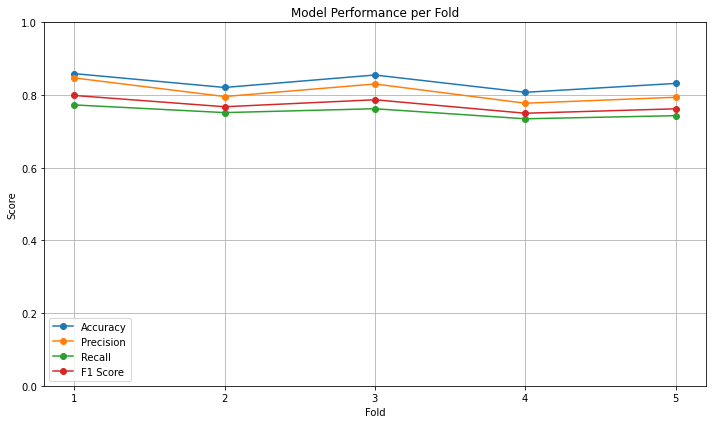

In [8]:
import matplotlib.pyplot as plt

# Plot metrics across folds
plt.figure(figsize=(10, 6))
for i, metric in enumerate(metric_names):
    plt.plot(range(1, 6), metrics_array[:, i], marker='o', label=metric)

plt.title('Model Performance per Fold')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.xticks(range(1, 6))
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

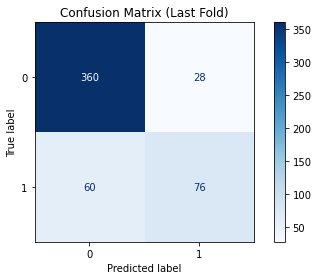

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix of the last fold
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix (Last Fold)')
plt.tight_layout()
plt.show()